In [1]:
# ----------------------------------------------------------------------------------------------------------------------
# Explainable Artificial Intelligence (XAI) unveils novel insights for enhanced prognosis in HCC patients
# ----------------------------------------------------------------------------------------------------------------------

# import relevant libraries and packages
#-----------------------------------------------------------------------------------------------------------------------
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from pandas import ExcelWriter
from pandas import ExcelFile
import os
import sys
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, mean_squared_error, r2_score, make_scorer, plot_confusion_matrix
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler
import shap
shap.initjs()
from time import time
print ('All libraries, tools, and functions have been succesfully uploaded')

All libraries, tools, and functions have been succesfully uploaded


In [2]:
def read_data(file_name,base_dir):
    df      = os.path.join(base_dir,file_name)
    df_read = pd.read_excel(df, thousands=r',')                                   
    return df_read

base_dir = r"C:\Users\wlv446\Documents\Elizabeth's HCC Analysis"
filename = r"GSE14520-GPL3921.gene.xlsx"

df_data = read_data(filename, base_dir)

In [3]:
df_data.loc[(df_data['SURVIVAL_TIME'] < 60),  'Survival_Group'] = 1
df_data.loc[(df_data['SURVIVAL_TIME'] >= 60),  'Survival_Group'] = 0
df_data['Survival_Group'] = df_data['Survival_Group'].replace(np.nan, 0)

df_data

,Sample_ID,PATIENT_ID,PATIENT,SURVIVAL_TIME,STATUS,DDR1,RFC2,HSPA6,PAX8,GUCA1A,...,ZNF512B,SIDT2,MYO15B,LOC729137,C12orf47,FLJ22167///CHST5,SNORA71C///LOC388796///SNORA71B,FLJ21865,LOC23117,Survival_Group
0,HCCDB-6.S1,HCCDB-6.P1,LCS-079,28.2,Dead,5.2795,4.7685,8.0835,3.477,3.5295,...,7.397,6.563,5.346,3.666,4.744,3.623,3.568,5.375,4.040,1.0
1,HCCDB-6.S2,HCCDB-6.P2,LCS-092,9.5,Dead,6.0140,4.4400,4.0985,3.530,3.6145,...,6.885,7.548,4.052,4.479,4.433,3.688,3.892,5.801,3.798,1.0
2,HCCDB-6.S3,HCCDB-6.P3,LCS-101,66.1,Alive,6.3505,4.3280,3.7135,3.656,4.2130,...,7.960,7.675,4.732,3.849,4.294,3.772,3.770,6.081,3.869,0.0
3,HCCDB-6.S4,HCCDB-6.P4,LCS-083,67.4,Alive,4.8010,4.0595,4.3385,3.859,3.5185,...,7.291,7.501,5.175,4.121,4.855,3.857,3.693,6.440,5.747,0.0
4,HCCDB-6.S5,HCCDB-6.P5,LCS-095,66.6,Alive,5.8930,4.1425,4.0285,3.551,3.4305,...,7.798,7.928,5.665,3.844,4.495,3.754,3.562,6.151,4.867,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,HCCDB-6.S227,HCCDB-6.P227,LCS-006,NaN,NaN,8.5710,5.4495,5.3285,3.578,3.3710,...,6.002,6.746,5.053,4.084,4.317,3.654,5.079,5.640,3.786,0.0
227,HCCDB-6.S228,HCCDB-6.P228,LCS-026,NaN,NaN,4.9835,4.4330,4.1175,3.487,3.2350,...,7.190,7.690,5.463,3.851,4.306,3.747,3.807,5.738,4.909,0.0
228,HCCDB-6.S229,HCCDB-6.P229,LCS-128,NaN,NaN,5.0130,4.8290,4.1455,3.380,3.3200,...,7.409,8.063,5.857,3.743,4.149,4.014,3.724,5.886,4.743,0.0
229,HCCDB-6.S230,HCCDB-6.P230,LCS-168,NaN,NaN,4.9675,4.3085,4.2410,3.706,3.6605,...,7.641,8.350,5.815,3.841,4.368,3.921,3.789,6.526,5.475,0.0


In [4]:
X = df_data.iloc[:,5:-1].to_numpy()

Y = df_data['Survival_Group'].to_numpy()

oversample = RandomOverSampler(random_state=25)

X_over, Y_over = oversample.fit_resample(X, Y)
train_X, test_X, train_y, test_y = train_test_split(X_over, Y_over, test_size=0.25, random_state=25)

# Extra Trees Classifier (ETC)

In [5]:
t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = ExtraTreesClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

Time taken to train the model: 0.01 minutes
Accuracy: 95.29%
Precision: 92.11%
Recall: 97.22%
F1 Score: 94.59%
ROC AUC: 95.55%


# Global Explainability - Top 5 - ETC

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


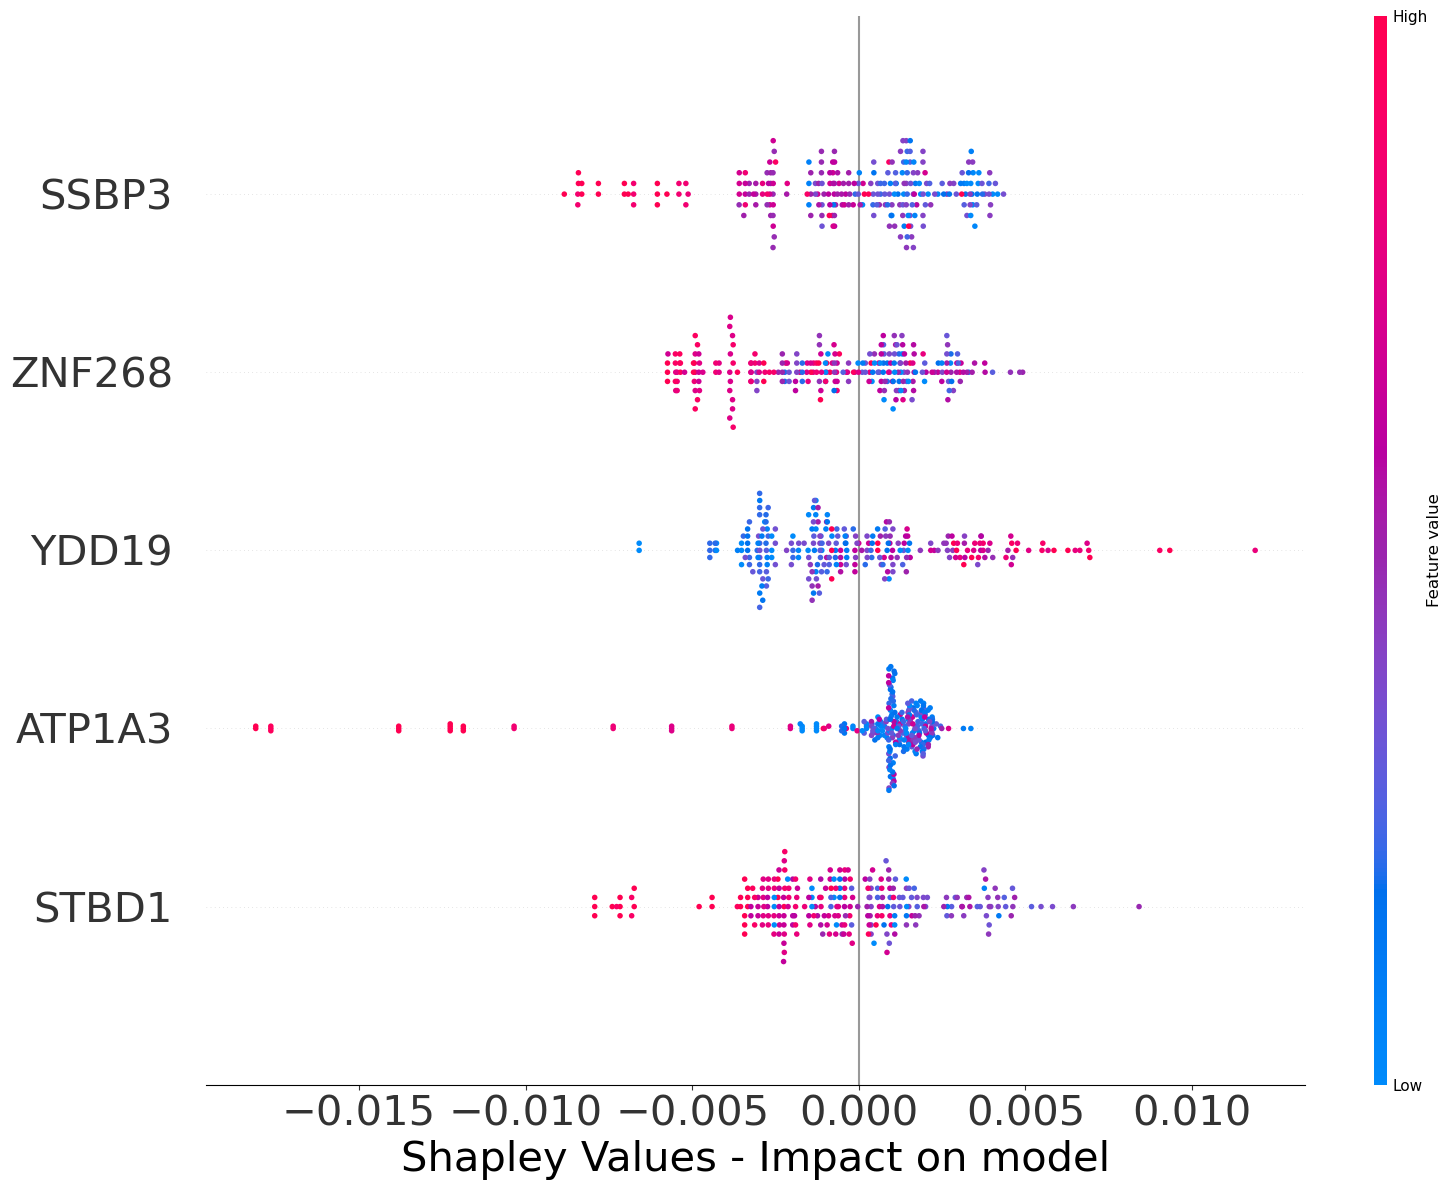

In [6]:
Features = df_data.iloc[:,5:-1].columns
shap_values = shap.TreeExplainer(gs_cv).shap_values(train_X)
shap.summary_plot(shap_values[1], train_X, feature_names=Features, plot_size=(16,12), max_display=5, show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.tight_layout(pad=1.08)
plt.savefig('Feature Importance Genes Only - ETC - Top 5 - select.tiff', format='tiff', dpi=300, bbox_inches ='tight')

# Random Forest Classifier (RFC)

In [7]:
t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = RandomForestClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

Time taken to train the model: 0.01 minutes
Accuracy: 95.29%
Precision: 97.06%
Recall: 91.67%
F1 Score: 94.29%
ROC AUC: 94.81%


# Global Explainability - Top 5 - RFC

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


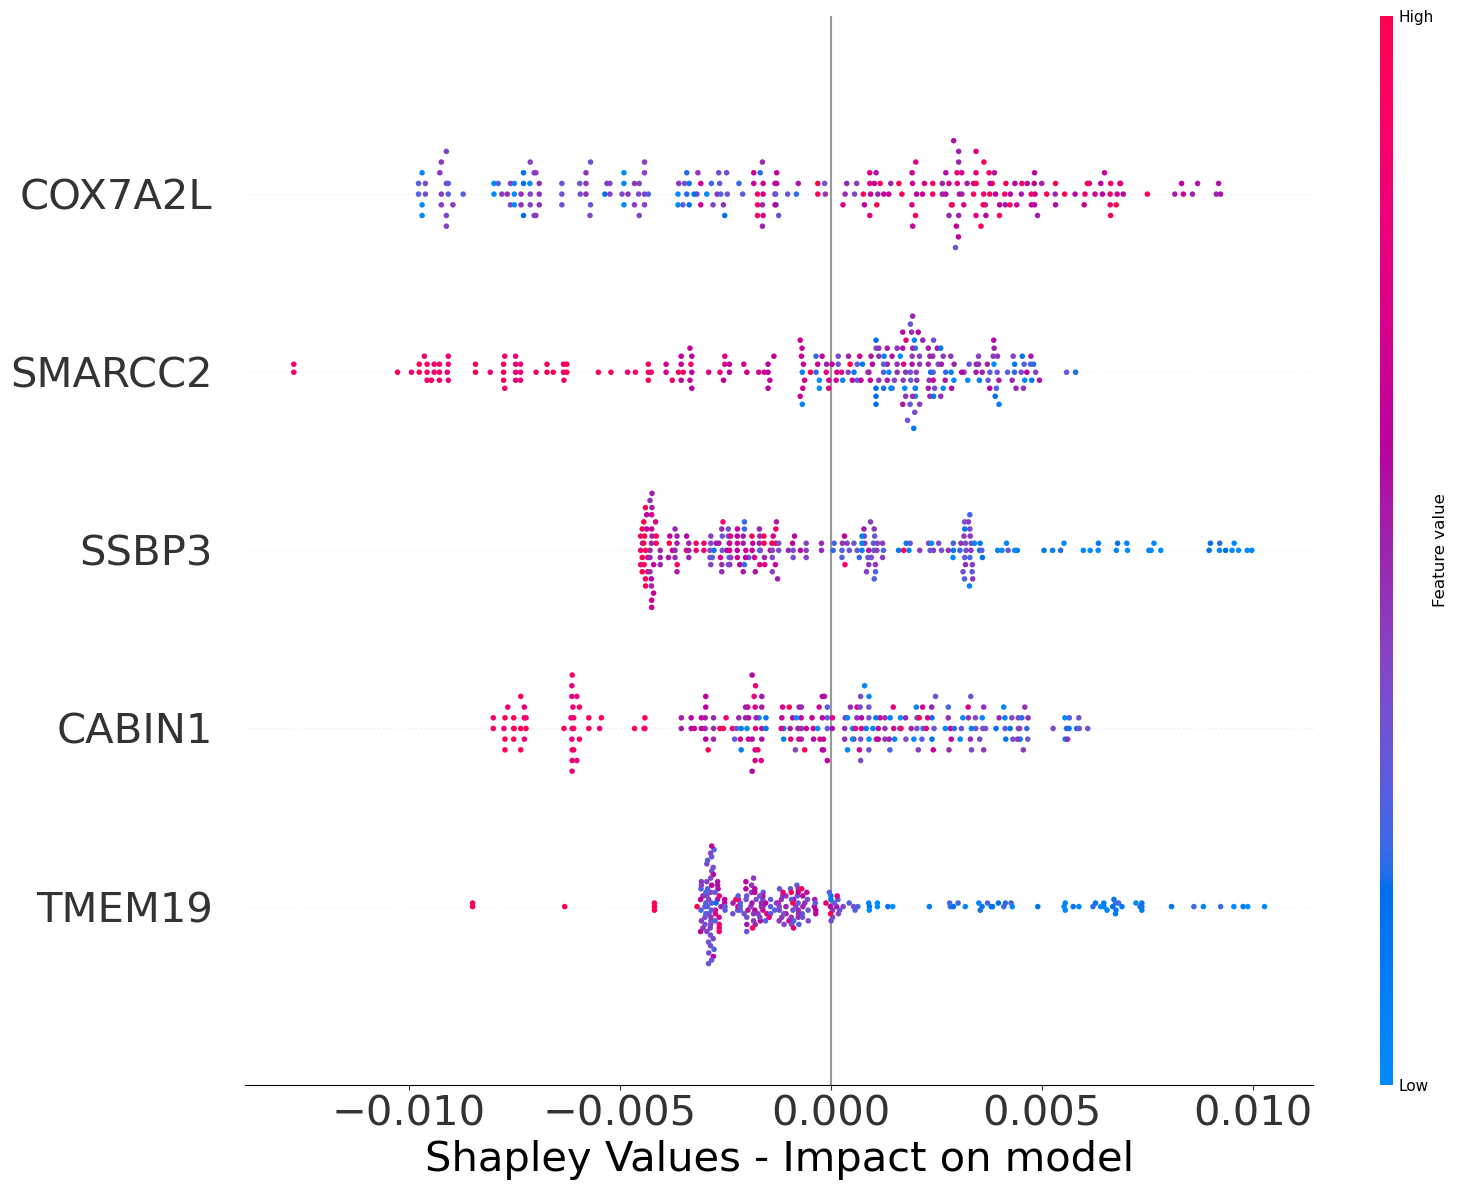

In [8]:
Features = df_data.iloc[:,5:-1].columns
shap_values = shap.TreeExplainer(gs_cv).shap_values(train_X)
shap.summary_plot(shap_values[1], train_X, feature_names=Features, plot_size=(16,12), max_display=5, show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.tight_layout(pad=1.08)
plt.savefig('Feature Importance Genes Only - RFC - Top 5 - select.tiff', format='tiff', dpi=300, bbox_inches ='tight')

# XGBoost Classifier (XGBoost)

In [9]:
t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = XGBClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:51:33] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to train the model: 0.03 minutes
Accuracy: 90.59%
Precision: 100.00%
Recall: 77.78%
F1 Score: 87.50%
ROC AUC: 88.89%


# Global Explainability - Top 5 - XGBoost

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


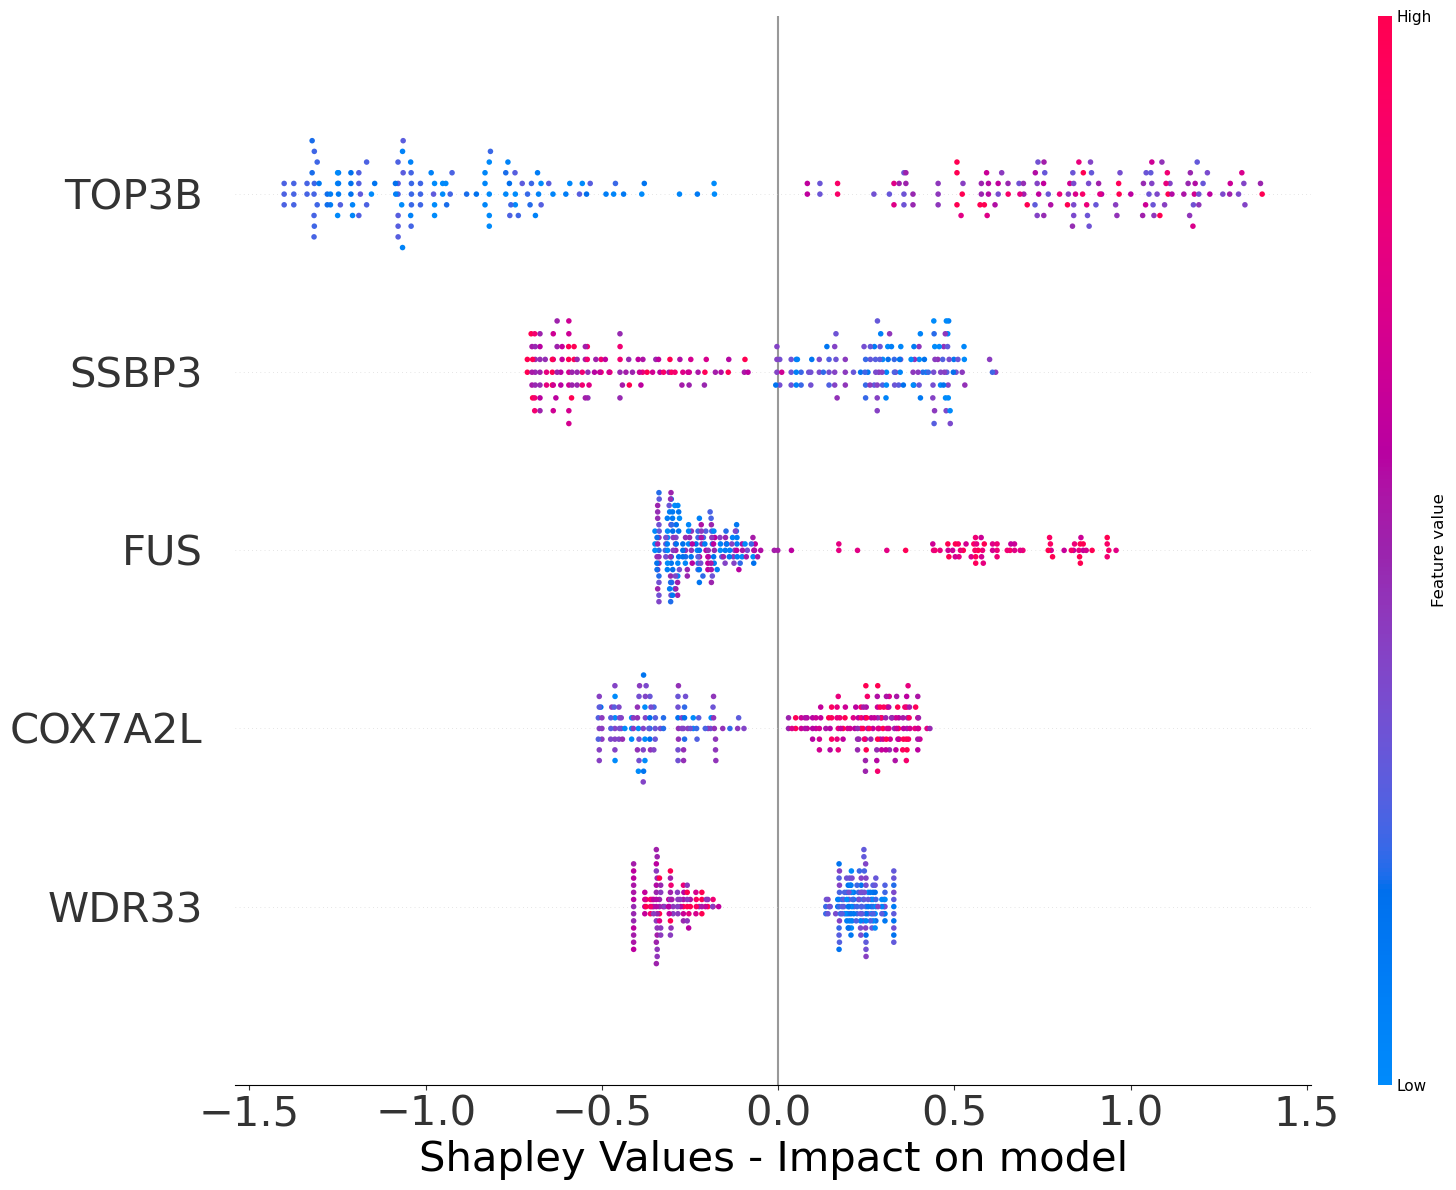

In [10]:
Features = df_data.iloc[:,5:-1].columns
shap_values = shap.TreeExplainer(gs_cv).shap_values(train_X)
shap.summary_plot(shap_values, train_X, feature_names=Features, plot_size=(16,12), max_display=5, show=False)
plt.xlabel('Shapley Values - Impact on model', fontsize=30)
plt.tick_params(labelsize=30)
plt.tight_layout(pad=1.08)
plt.savefig('Feature Importance Genes Only - XGB - Top 5 - select.tiff', format='tiff', dpi=300, bbox_inches ='tight')

# Local Explainability - TOP3B, SSBP3, and COX7A2L

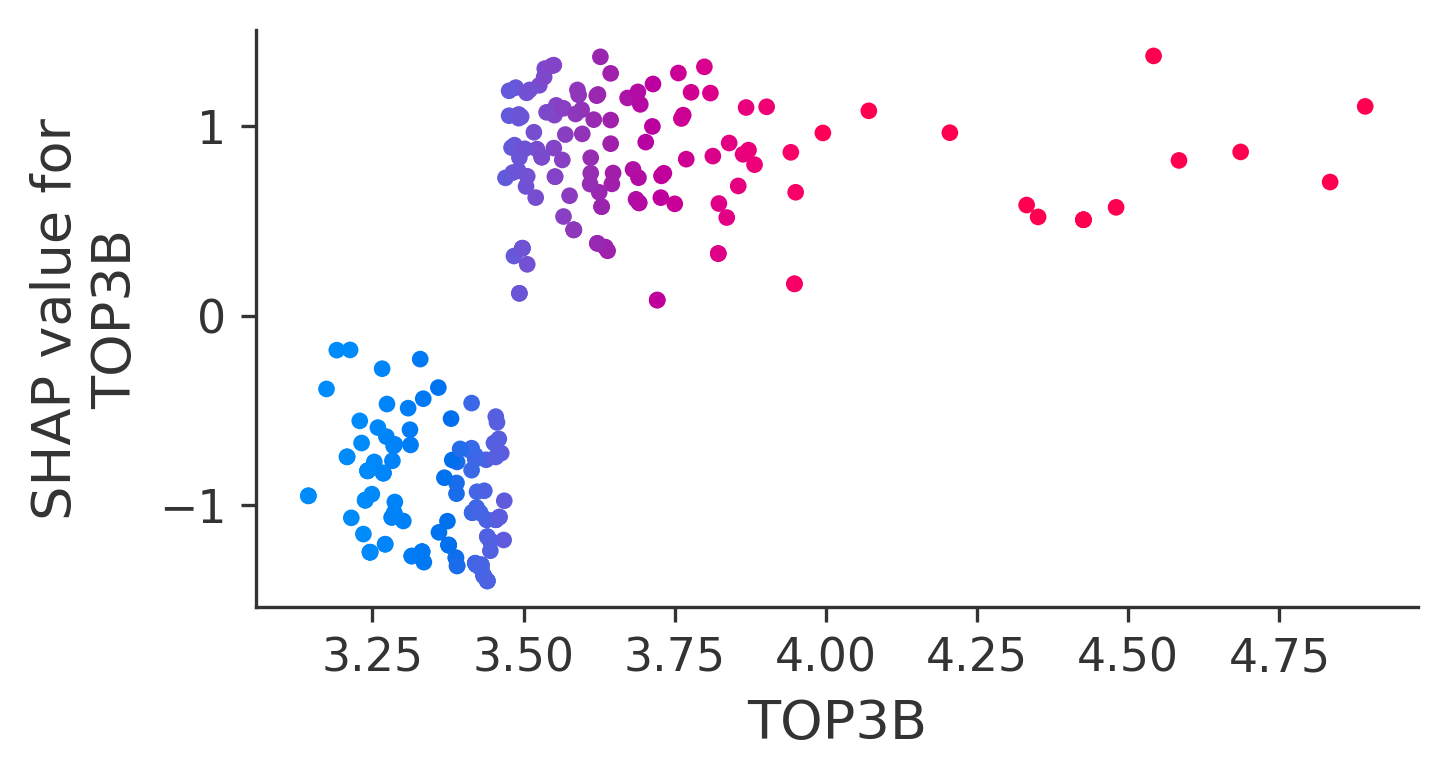

In [11]:
fig = plt.figure(figsize=(5,2.5),dpi=300)
ax1 = fig.add_subplot(1,1,1)
   
shap.dependence_plot('TOP3B', shap_values, train_X, Features, ax=ax1, show=False, interaction_index='TOP3B')
plt.savefig('Feature Interaction - TOP3B.tiff', format='tiff', dpi=300, bbox_inches ='tight')

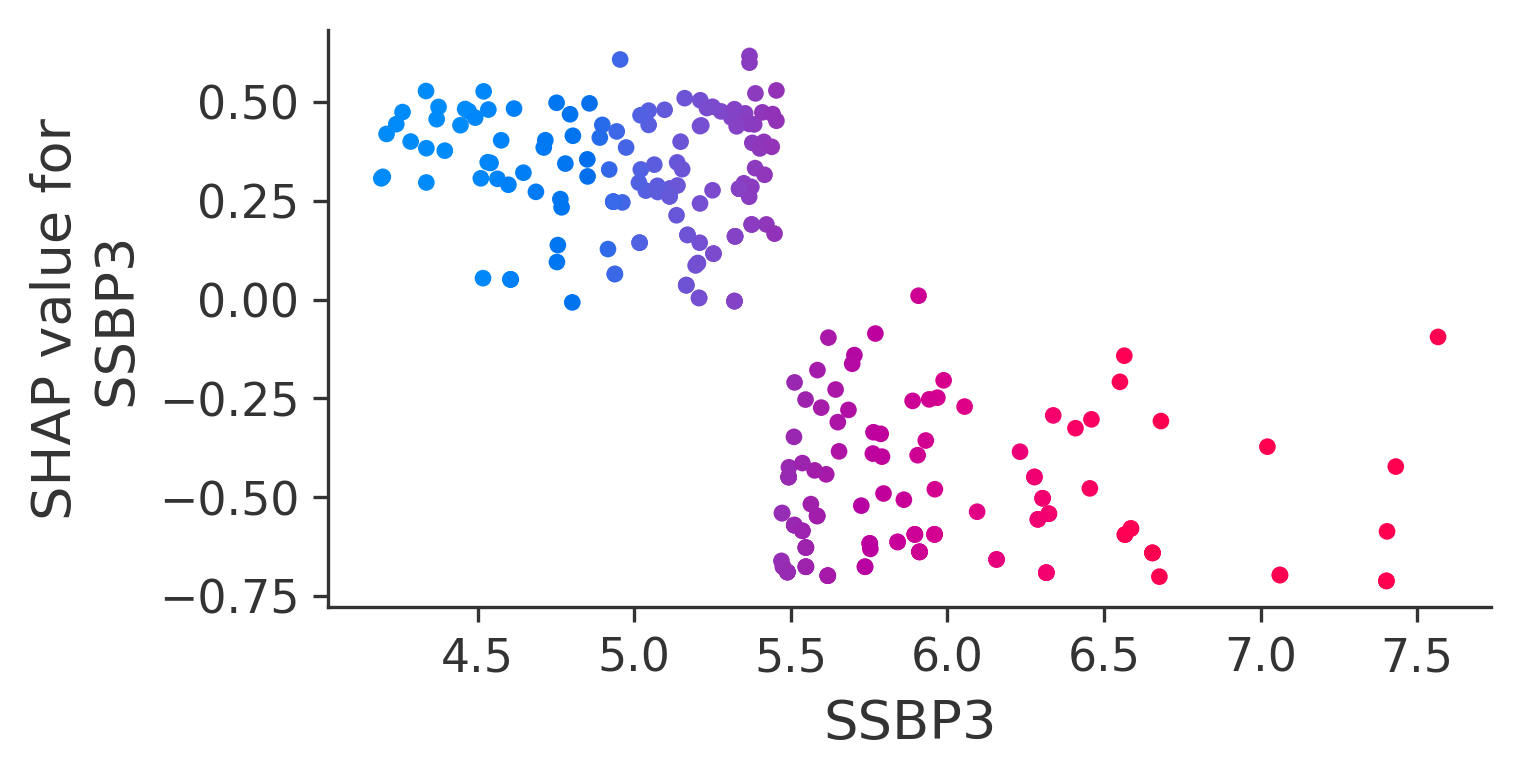

In [12]:
fig = plt.figure(figsize=(5,2.5),dpi=300)
ax1 = fig.add_subplot(1,1,1)
   
shap.dependence_plot('SSBP3', shap_values, train_X, Features, ax=ax1, show=False, interaction_index='SSBP3')
plt.savefig('Feature Interaction - SSBP3.tiff', format='tiff', dpi=300, bbox_inches ='tight')

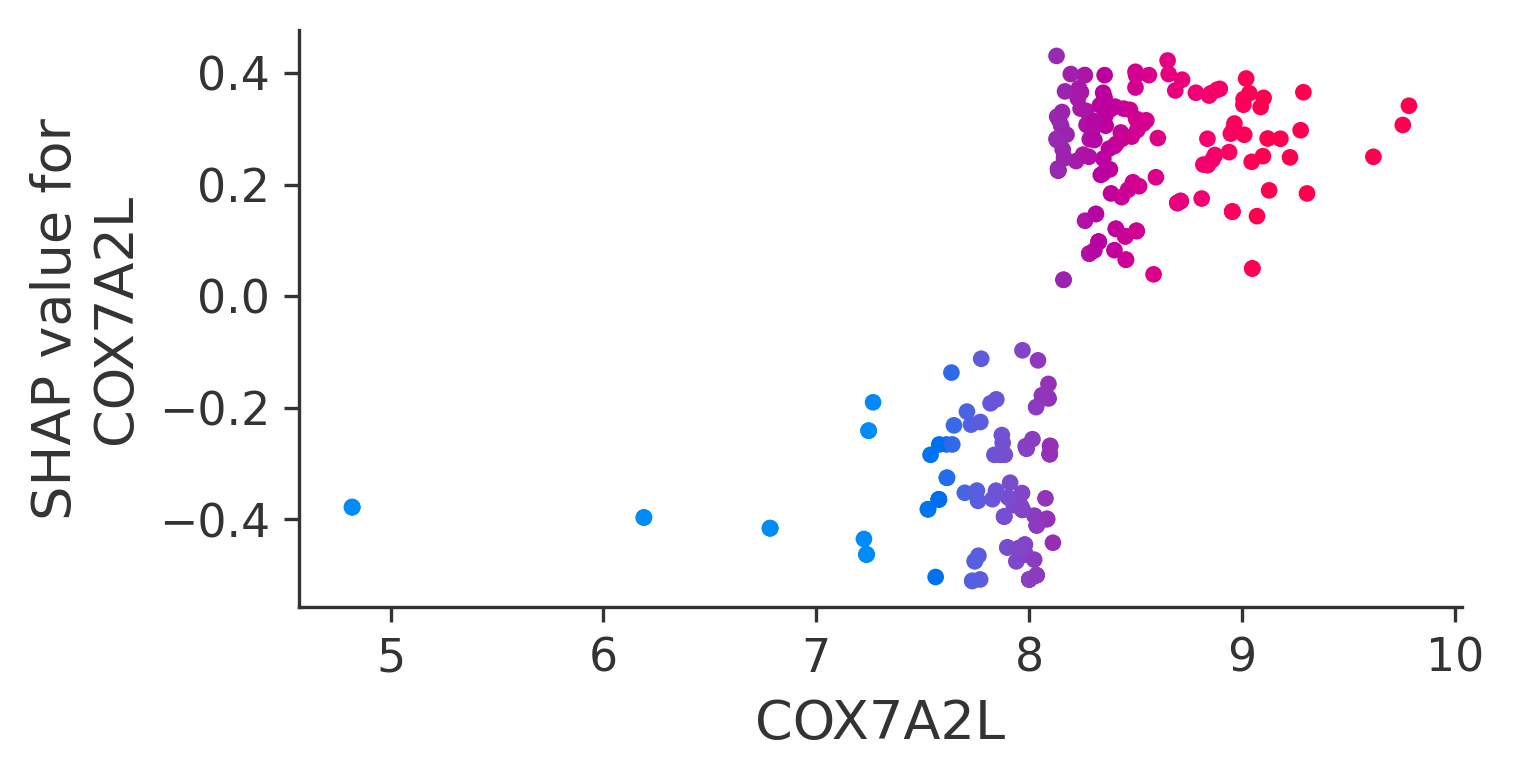

In [13]:
fig = plt.figure(figsize=(5,2.5),dpi=300)
ax1 = fig.add_subplot(1,1,1)
   
shap.dependence_plot('COX7A2L', shap_values, train_X, Features, ax=ax1, show=False, interaction_index='COX7A2L')
plt.savefig('Feature Interaction - COX7A2L.tiff', format='tiff', dpi=300, bbox_inches ='tight')

# Quantification of explainability: Analyzing the inflection points using conditional probability - Individual Explainability of TOP3B, SSBP3, and COX7A2L

In [14]:
print("##################### Probability of >= 5 Year survival #####################")

print("##############################################################################################")
print("### Initial ####")
print(np.round(100*(df_data[((df_data['Survival_Group']==0))]['Survival_Group'].count())/df_data['Survival_Group'].count(),1))
print("##############################################################################################")

print("##############################################################################################")

true_pred = df_data[(df_data['SSBP3'] > 5.5) &
                             (df_data['Survival_Group']==0)]['Survival_Group'].count()               

total_cases = df_data[(df_data['SSBP3'] > 5.5)]['Survival_Group'].count()

print("### SSBP3 > 5.5 ####")
print(np.round((100 * true_pred/total_cases),1))
print(true_pred)
print(total_cases)

print("##############################################################################################")

true_pred = df_data[(df_data['COX7A2L'] < 8) &
                             (df_data['Survival_Group']==0)]['Survival_Group'].count()               

total_cases = df_data[(df_data['COX7A2L'] < 8)]['Survival_Group'].count()

print("### COX7A2L < 8 ####")
print(np.round((100 * true_pred/total_cases),1))
print(true_pred)
print(total_cases)

print("##############################################################################################")

true_pred = df_data[(df_data['TOP3B'] < 3.5) &
                             (df_data['Survival_Group']==0)]['Survival_Group'].count()               

total_cases = df_data[(df_data['TOP3B'] < 3.5)]['Survival_Group'].count()

print("### TOP3B < 3.5 ####")
print(np.round((100 * true_pred/total_cases),1))
print(true_pred)
print(total_cases)

print("##############################################################################################")



##################### Probability of >= 5 Year survival #####################
##############################################################################################
### Initial ####
26.8
##############################################################################################
##############################################################################################
### SSBP3 > 5.5 ####
42.0
37
88
##############################################################################################
### COX7A2L < 8 ####
40.6
26
64
##############################################################################################
### TOP3B < 3.5 ####
41.2
47
114
##############################################################################################


# Quantification of explainability: Analyzing the inflection points using conditional probability - Combinatorial Explainability of TOP3B, SSBP3, and COX7A2L

In [15]:
print("##############################################################################################")

print("##############################################################################################")

true_pred = df_data[(df_data['SSBP3'] > 5.5) & (df_data['COX7A2L'] < 8) & (df_data['TOP3B'] < 3.5) &
                             (df_data['Survival_Group']==0)]['Survival_Group'].count()               

total_cases = df_data[(df_data['SSBP3'] > 5.5) & (df_data['COX7A2L'] < 8) & (df_data['TOP3B'] < 3.5)]['Survival_Group'].count()

print("### SSBP3 > 5.5 & COX7A2L < 8 & TOP3B < 3.5 ####")
print(np.round((100 * true_pred/total_cases),1))
print(true_pred)
print(total_cases)
print("##############################################################################################")

##############################################################################################
##############################################################################################
### SSBP3 > 5.5 & COX7A2L < 8 & TOP3B < 3.5 ####
66.7
16
24
##############################################################################################


# Testing individual predictability of TOP3B

In [16]:
X = df_data[['TOP3B']].to_numpy()

Y = df_data['Survival_Group'].to_numpy()

oversample = RandomOverSampler(random_state=25)
# fit and apply the transform
X_over, Y_over = oversample.fit_resample(X, Y)
train_X, test_X, train_y, test_y = train_test_split(X_over, Y_over, test_size=0.25, random_state=25)

t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = XGBClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

[17:51:36] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to train the model: 0.00 minutes
Accuracy: 82.35%
Precision: 83.87%
Recall: 72.22%
F1 Score: 77.61%
ROC AUC: 81.01%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


# Testing individual predictability of SSBP3

In [17]:
X = df_data[['SSBP3']].to_numpy()

Y = df_data['Survival_Group'].to_numpy()

oversample = RandomOverSampler(random_state=25)
# fit and apply the transform
X_over, Y_over = oversample.fit_resample(X, Y)
train_X, test_X, train_y, test_y = train_test_split(X_over, Y_over, test_size=0.25, random_state=25)

t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = XGBClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[17:51:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to train the model: 0.00 minutes
Accuracy: 84.71%
Precision: 89.66%
Recall: 72.22%
F1 Score: 80.00%
ROC AUC: 83.05%


# Testing individual predictability of COX7A2L

In [18]:
X = df_data[['COX7A2L']].to_numpy()

Y = df_data['Survival_Group'].to_numpy()

oversample = RandomOverSampler(random_state=25)
# fit and apply the transform
X_over, Y_over = oversample.fit_resample(X, Y)
train_X, test_X, train_y, test_y = train_test_split(X_over, Y_over, test_size=0.25, random_state=25)

t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = XGBClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

[17:51:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Time taken to train the model: 0.00 minutes
Accuracy: 85.88%
Precision: 87.50%
Recall: 77.78%
F1 Score: 82.35%
ROC AUC: 84.81%


# Testing individual predictability of AFP

In [19]:
X = df_data[['AFP']].to_numpy()

Y = df_data['Survival_Group'].to_numpy()

oversample = RandomOverSampler(random_state=25)
# fit and apply the transform
X_over, Y_over = oversample.fit_resample(X, Y)
train_X, test_X, train_y, test_y = train_test_split(X_over, Y_over, test_size=0.25, random_state=25)

t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = XGBClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

[17:51:37] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Time taken to train the model: 0.00 minutes
Accuracy: 82.35%
Precision: 75.61%
Recall: 86.11%
F1 Score: 80.52%
ROC AUC: 82.85%


# Testing individual explainability of AFP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


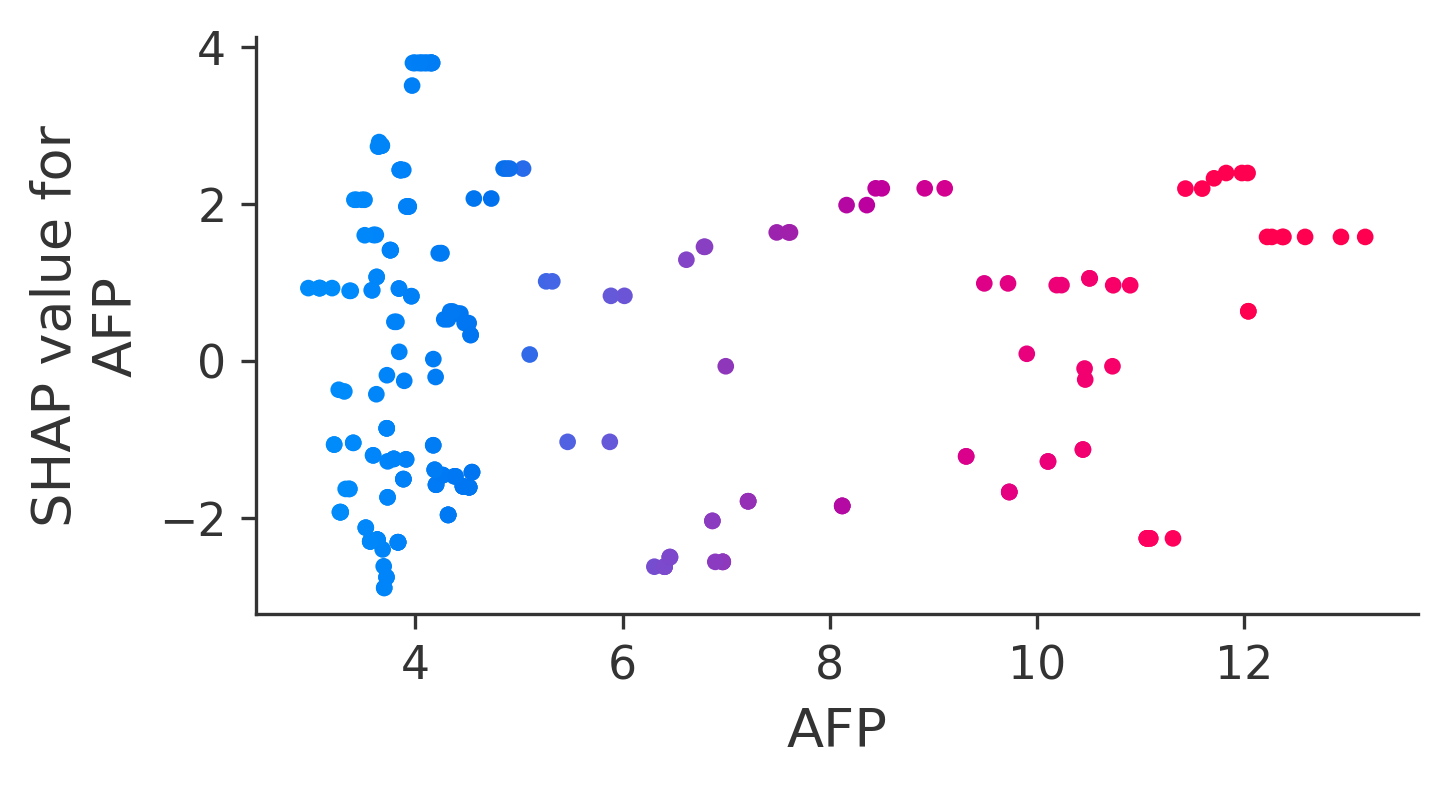

In [20]:
Features = df_data[['AFP']].columns
shap_values = shap.TreeExplainer(gs_cv).shap_values(train_X)

fig = plt.figure(figsize=(5,2.5),dpi=300)
ax1 = fig.add_subplot(1,1,1)
shap.dependence_plot('AFP', shap_values, train_X, Features, ax=ax1, show=False, interaction_index='AFP')
plt.savefig('Feature Interaction - AFP.tiff', format='tiff', dpi=300, bbox_inches ='tight')

# Testing combinatorial predictability of TOP3B, SSBP3, and COX7A2L

In [21]:
X = df_data[['TOP3B','SSBP3','COX7A2L']].to_numpy()

Y = df_data['Survival_Group'].to_numpy()

oversample = RandomOverSampler(random_state=25)
# fit and apply the transform
X_over, Y_over = oversample.fit_resample(X, Y)
train_X, test_X, train_y, test_y = train_test_split(X_over, Y_over, test_size=0.25, random_state=25)

t0 = time()
np.random.seed(25)
scoring_param = make_scorer(roc_auc_score,greater_is_better=True)

gs_cv = XGBClassifier()
gs_cv.fit(train_X, train_y.ravel())

t1 = time()
Time_Taken = (t1-t0)/60
print("Time taken to train the model: %0.2f" % Time_Taken,"minutes")

y_pred = gs_cv.predict(test_X)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(test_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

precision = precision_score(test_y, predictions)
print("Precision: %.2f%%" % (precision * 100.0))

recall = recall_score(test_y, predictions)
print("Recall: %.2f%%" % (recall * 100.0))

f1 = f1_score(test_y, predictions)
print("F1 Score: %.2f%%" % (f1 * 100.0))

fpr, tpr, thresholds = roc_curve(test_y, predictions)
roc_auc = auc(fpr, tpr)
print("ROC AUC: %.2f%%" % (roc_auc * 100.0))

[17:51:38] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Time taken to train the model: 0.00 minutes
Accuracy: 89.41%
Precision: 100.00%
Recall: 75.00%
F1 Score: 85.71%
ROC AUC: 87.50%


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
